# Project Overview
-----

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

 
Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.


|Variable|Description|
|---|---|
|Item_Identifier|Unique product ID|
|Item_Weight|Weight of product|
|Item_Fat_Content|Whether the product is low fat or not|
|Item_Visibility|The % of total display area of all products in a store allocated to the particular product|
|Item_Type|The category to which the product belongs|
|Item_MRP|Maximum Retail Price (list price) of the product|
|Outlet_Identifier|Unique store ID|
|Outlet_Establishment_Year|The year in which store was established|
|Outlet_Size|The size of the store in terms of ground area covered|
|Outlet_Location_Type|The type of city in which the store is located|
|Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket|
|Item_Outlet_Sales|Sales of the product in the particulat store. This is the outcome variable to be predicted.|

Root Mean Square Error (RMSE) will be used to measure performance.

## Potential Hypotheses
Let's put together a set of store and product level hypothesis that we can use to guide the analysis. The data may not exist to verify these hypothesis, but nontheless it helps to frame our thinking around the problem.

Here we are thinking about the influence on sales.

### Store Level Hypotheses

- **City type:** Stores located in urban or Tier 1 cities should have higher sales because of the higher income levels of people there.
- **Population Density:** Stores located in densely populated areas should have higher sales because of more demand.
- **Store Capacity:** Stores which are very big in size should have higher sales as they act like one-stop-shops and people would prefer getting everything from one place
- **Competitors:** Stores having similar establishments nearby should have less sales because of more competition.
- **Marketing:** Stores which have a good marketing division should have higher sales as it will be able to attract customers through the right offers and advertising.
- **Location:** Stores located within popular marketplaces should have higher sales because of better access to customers.
- **Customer Behavior:** Stores keeping the right set of products to meet the local needs of customers will have higher sales.
- **Ambience:** Stores which are well-maintained and managed by polite and humble people are expected to have higher footfall and thus higher sales.
- **Listing Price**: There may be a difference in listing prices for the same product at difference stores. This may influence the sales.

### Product Level Hypotheses

- **Brand:** Branded products should have higher sales because of higher trust in the customer.
- **Packaging:** Products with good packaging can attract customers and sell more.
- **Utility:** Daily use products should have a higher tendency to sell as compared to the specific use products.
- **Display Area:** Products which are given bigger shelves in the store are likely to catch attention first and sell more.
- **Visibility in Store:** The location of product in a store will impact sales. Ones which are right at entrance will catch the eye of customer first rather than the ones in back. Product near the checkout isles, like chocoloates and candy, will attract more sales. 
- **Advertising:** Better advertising of products in the store should attract higher sales in most cases.
- **Promotional Offers:** Products accompanied with attractive offers and discounts will sell more.
- **Healthly Products:** Products recognisable as health-brands and/or low-fat or fat-free, may sell more products.
- **Listing Price:** While Brand is important when purchasing a product, cost-conscious consumers may seek out lower-cost versions of the same product. Whether this helps or hinders sales depends on the volumes sold.

# Data Exploration

## Setup

In [1]:
import pandas as pd
import numpy as np
import os

# To serialise models
from sklearn.externals import joblib

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
#plt.rcParams['figure.figsize'] = 12, 8

import seaborn as sns
sns.set()

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "imagesV2")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")
def save_dataset(df, filename, extension="csv"):
    if not os.path.isdir(DATASETS_PATH):
        os.makedirs(DATASETS_PATH)
    path = os.path.join(DATASETS_PATH, filename + "." + extension)
    print("Saving dataset", filename)
    df.to_csv(path, index=False)
    
SUBMISSIONS_PATH = os.path.join(PROJECT_ROOT_DIR, "submissions")
def save_submission(df, filename, extension="csv"):
    if not os.path.isdir(SUBMISSIONS_PATH):
        os.makedirs(SUBMISSIONS_PATH)
    path = os.path.join(SUBMISSIONS_PATH, filename + "." + extension)
    print("Saving submission", filename)
    df.to_csv(path, index=False)

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
def save_model(model, filename):
    if not os.path.isdir(MODELS_PATH):
        os.makedirs(MODELS_PATH)
    path = os.path.join(MODELS_PATH, filename + "." + "pkl")
    print("Saving model", filename)
    joblib.dump(model, path)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

## Loading Data

In [2]:
#Read files:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

We'll combine the training and testing data so that we don't have to perform the same feature engineering operations twice. By maintaning a `source` column, we can ensure that the originl train vs test split is maintained. 

In [3]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test], ignore_index=True, sort=False)
print (train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [4]:
#Check missing values:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

The missing `Outlet_Sales` values are from the test set we just concatented, as can be confirmed by the shape of the test data. We'll need to handle the missing values in `Item_Weight`, which are numerical and `Outlet_Size`, which are categorical. 

In [5]:
#Numerical data summary:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


- `Item_Visibility` has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
- `Outlet_Establishment_Years` vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
- The lower ‘count’ of `Item_Weight` and `Item_Outlet_Sales` confirms the findings from the missing value check.

Exploring the categorical variables.

In [6]:
#Number of unique values in each:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

- This tells us that there are **1559** products and **10** outlets/stores (which was also mentioned in problem statement). 
- `Item_Type` has **16** unique values. 
- `Item_Fat_Content` has **5** unique values which seems a little odd. It will be useful to understand how fat content influence sales.

Let’s explore further using the frequency of different categories in each nominal variable. I’ll exclude the ID and source variables for obvious reasons.

In [7]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

- `Item_Fat_Content`: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.
- `Item_Type`: Not all categories have substantial numbers. It looks like combining them can give better results.
- `Outlet_Type`: Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea (by comparing sales per outlet type) before doing it.

# Data Cleaning

## Imputating Item_Weight Missing Values
We'll use the average weight of a particular item to impute the missing `Item_Weight` values. As opposed to filling in this value with the mean, median or mode of the column as a whole, this approach ensures that we have correctly matched each item's true weight.

In [8]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')
item_avg_weight.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [9]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


## Imputing Outlet_Size Missing Values
To fill in the missing values for `Outlet_Size`, we will find the mode `Outlet_Size` for each `Outlet_Type` and use that value. Again rather than using the generic mode of all values, we are ensuring that we better match the true value. 

In [10]:
#Import mode function:
from scipy.stats import mode

outlet_size_mode = data.dropna(subset=['Outlet_Size']).pivot_table(values='Outlet_Size', columns='Outlet_Type',
                                                aggfunc=(lambda x:mode(x.astype(str)).mode[0]), dropna=True).unstack()

print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Outlet_Size values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(data['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type                   
Grocery Store      Outlet_Size     Small
Supermarket Type1  Outlet_Size     Small
Supermarket Type2  Outlet_Size    Medium
Supermarket Type3  Outlet_Size    Medium
dtype: object

Orignal #missing: 4016
0


# Feature Engineering

## Consider combining categories in Outlet_Type
Let's check if it would be wise to combine `Supermarket Type2` and `Supermarket Type3`. 

In [11]:
#Check the mean sales by type:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


Since there is a substantial difference in their total sales, we'll leave them alone.

## Modify Item_Visibility
Let's impute the `Item_Visibility` zero values with the average for that specific product. 

In [12]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In step 1 we hypothesized that products with higher visibility are likely to sell more. But along with comparing products on absolute terms, we should look at the visibility of the product in that particular store as compared to the mean visibility of that product across all stores. This will give some idea about how much importance was given to that product in a store as compared to other stores. We can use the `visibility_avg` variable made above to achieve this.

In [13]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']], axis=1)
print (data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


## Create a broad category of Type of Item
Earlier we saw that the `Item_Type` variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each, but there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [14]:
#Item type combine:
data['Item_Identifier'].value_counts()
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

## Combine Categories based on Sales
Let's combine categories based on sales. The ones with high average sales could be combined together.

## Determine the years of operation of a store
As opposed to a static year value, it will be more useful to use the age of the store. We calculate this from 2013 since this is when the data is applicable until.

In [15]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

- This shows stores which are **4-28** years old

## Modify categories of Item_Fat_Content
Let's correct the typos in the `Item_Fat_Content` variable. 

In [16]:
#Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


Let's create a seperate `Item_Fat_Content` category to house non-consumable's, for which a fat content value is not applicable. 

In [17]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

## Numerical and One-Hot Coding of Categorical variables
scikit-learn accepts only numerical variables so we'll convert all categories of nominal variables into numeric types. Also, I wanted `Outlet_Identifier` as a variable as well. So I created a new variable `Outlet` same as Outlet_Identifier and coded that. `Outlet_Identifier` should remain as it is, because it will be required in the submission file.

Lets start with coding all categorical variables as numeric using `LabelEncoder` from sklearn’s preprocessing module.

In [18]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [19]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Visibility_MeanRatio,Item_Type_Combined,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,train,0.931078,1,14,9
1,DRC01,5.92,2,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,train,0.933420,0,4,3
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,train,0.960069,1,14,9
3,FDX07,19.20,2,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,2,2,0,732.3800,train,1.000000,1,15,0
4,NCD19,8.93,1,0.009780,Household,53.8614,OUT013,1987,0,2,1,994.7052,train,1.000000,2,26,1


One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the `Item_Fat_Content` has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. One hot coding will remove this variable and generate 3 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [20]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [21]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [22]:
# Viewing the dummy variables for each fat content type
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


## Exporting Data
We'll export modified versions of our training and test data that contain all of our feature engineering. This will allow us to easily build new models at a later stage with a clean set of data ready for modelling. 

In [23]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
save_dataset(train, "train_modified")
save_dataset(test, "test_modified")

Saving dataset train_modified
Saving dataset test_modified


# Model Building

## Load Data

In [24]:
train = pd.read_csv("datasets/train_modified.csv")
test = pd.read_csv("datasets/test_modified.csv")

In [25]:
print (train.shape)
train.dtypes

(8523, 34)


Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Identifier             object
Item_Outlet_Sales            float64
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             int64
Item_Fat_Content_1             int64
Item_Fat_Content_2             int64
Outlet_Location_Type_0         int64
Outlet_Location_Type_1         int64
Outlet_Location_Type_2         int64
Outlet_Size_0                  int64
Outlet_Size_1                  int64
Outlet_Size_2                  int64
Outlet_Type_0                  int64
Outlet_Type_1                  int64
Outlet_Type_2                  int64
Outlet_Type_3                  int64
Item_Type_Combined_0           int64
Item_Type_Combined_1           int64
Item_Type_Combined_2           int64
Outlet_0                       int64
Outlet_1                       int64
Outlet_2                       int64
O

## Creating Baseline Model
Lets start by making a baseline model. A baseline is one that requires no predictive model and its like an informed guess. For instance, in this case lets predict the sales as the overall average sales.

In [26]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
save_submission(base1, "baseline")
save_model(base1, "baseline")

Saving submission baseline
Saving model baseline


## Function to Fit and Generate Submission File
We'll create a generic function that can run cross-validation using different model types and output the results to a submission file, including all the neccessary columns required by the submission guidelines. This function is for a first-time run to ascertain which algorithm may perform best. As such, it doesnt allow for Grid or Random Search across different hyperparameters. We'll create a different function later that can handle that for model fine-tuning.

In [27]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    save_model(alg, filename)
    save_submission(submission, filename)
    
    #submission.to_csv("datasets/" + filename, index=False)

## Linear Regression Model

In [29]:
from sklearn.linear_model import LinearRegression, Ridge


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.72 | Min - 1074 | Max - 1213
Saving model linear_regression_model
Saving submission linear_regression_model
Saving figure linear_regression_coefficients


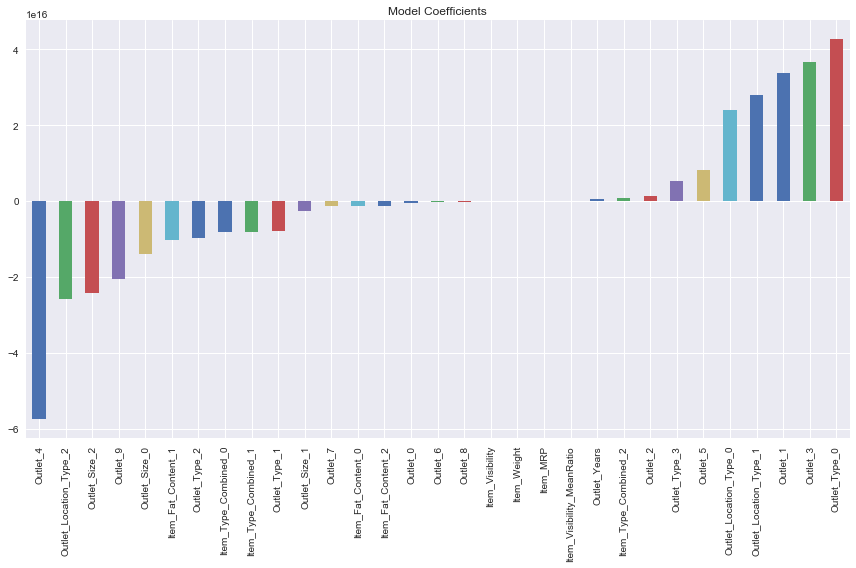

In [30]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg = LinearRegression(normalize=True)
modelfit(alg, train, test, predictors, target, IDcol, 'linear_regression_model')
coef = pd.Series(alg.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Model Coefficients', figsize=(12, 8))

save_fig('linear_regression_coefficients')

- We can see this is better than baseline model. But if you notice the coefficients, they are very large in magnitude which signifies overfitting. To cater to this, lets use a ridge regression model. 

## Ridge Regression Model


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217
Saving model ridge_regression_model
Saving submission ridge_regression_model
Saving figure ridge_regression_coefficients


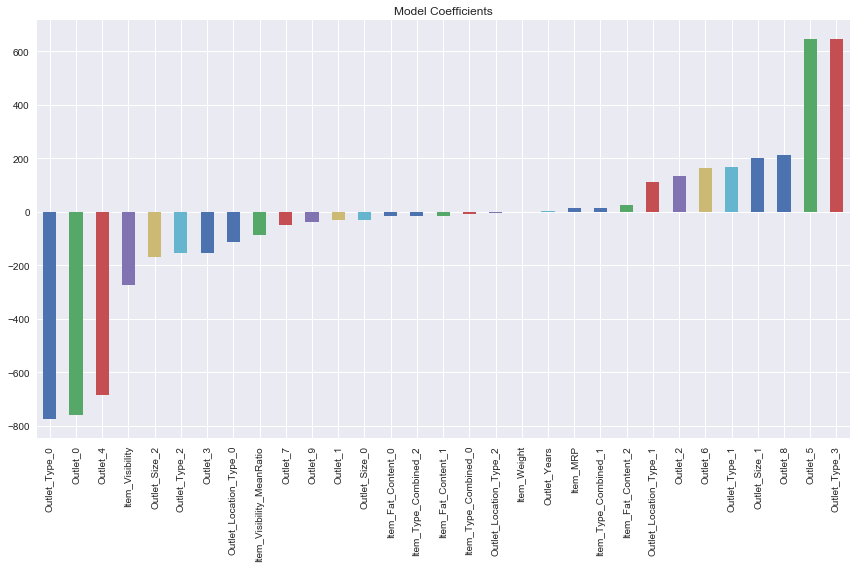

In [31]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg = Ridge(alpha=0.05,normalize=True)
modelfit(alg, train, test, predictors, target, IDcol, 'ridge_regression_model')
coef = pd.Series(alg.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Model Coefficients', figsize=(12, 8))

save_fig('ridge_regression_coefficients')

- Though the regression coefficients look better now, the score is about the same. You can tune the parameters of the model for slightly better results but I don’t think there will be a significant improvement. Even the cross-validation score is same so we can’t expect way better performance.

## SVM Model

In [32]:
from sklearn.svm import SVR


Model Report
RMSE : 1192
CV Score : Mean - 1194 | Std - 53.63 | Min - 1118 | Max - 1295
Saving model svm_model
Saving submission svm_model
Saving figure svm_coefficients


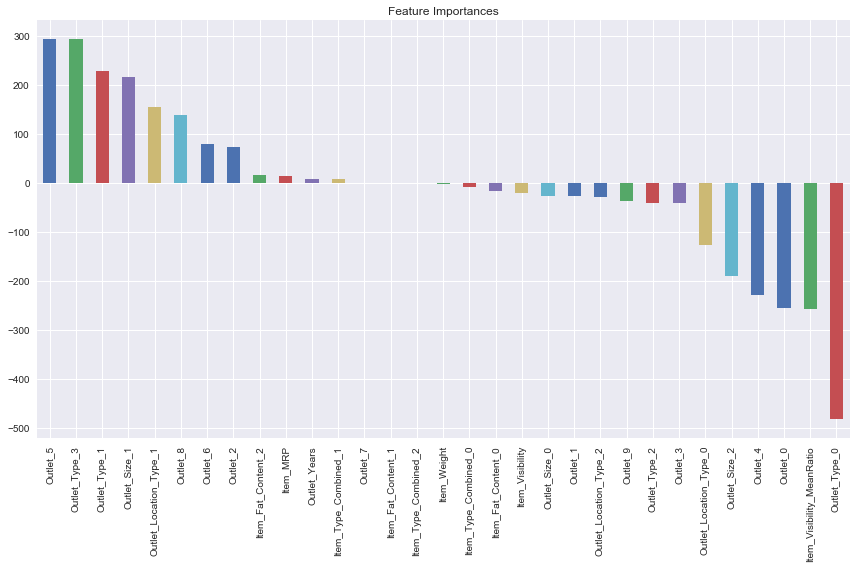

In [33]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg = SVR(kernel="linear")
modelfit(alg, train, test, predictors, target, IDcol, 'svm_model')
coef = pd.Series(alg.coef_[0], predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('svm_coefficients')

## Decision Tree Model

In [34]:
from sklearn.tree import DecisionTreeRegressor


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186
Saving model decision_tree_model_1
Saving submission decision_tree_model_1
Saving figure decision_tree_1_coefficients


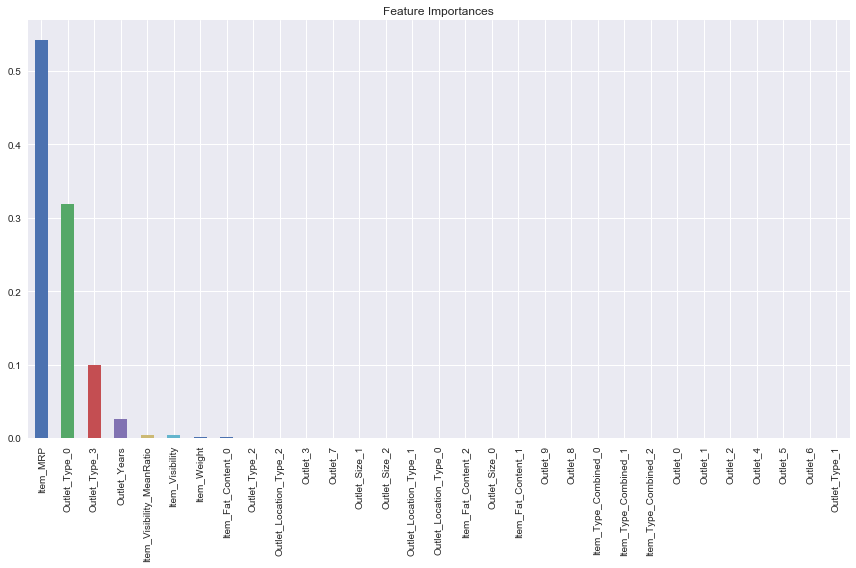

In [35]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg, train, test, predictors, target, IDcol, 'decision_tree_model_1')
coef = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('decision_tree_1_coefficients')

- Here you can see that the RMSE is 1058 and the mean CV error is 1091. This tells us that the model is slightly overfitting. Lets try making a decision tree with just top 4 variables, a max_depth of 8 and min_samples_leaf as 150.


Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172
Saving model decision_tree_model_2
Saving submission decision_tree_model_2
Saving figure decision_tree_2_coefficients


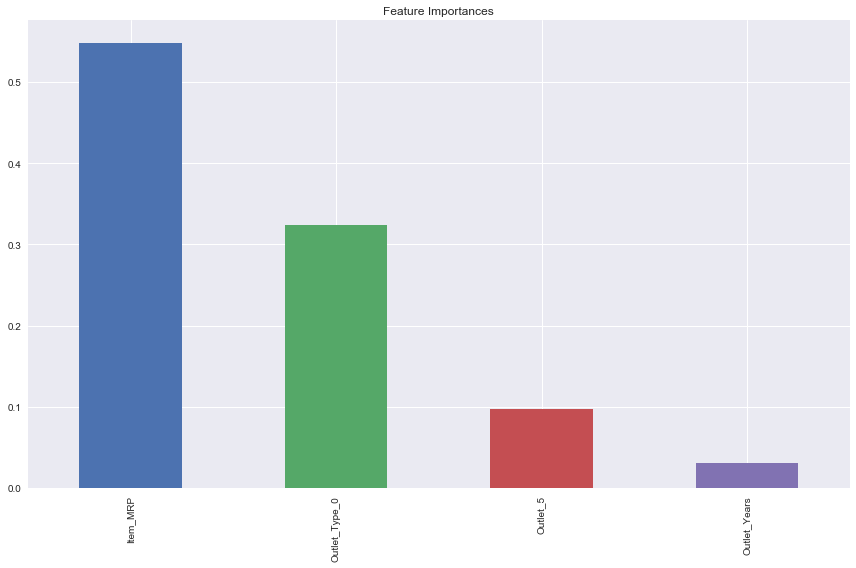

In [36]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg, train, test, predictors, target, IDcol, 'decision_tree_model_2')
coef = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('decision_tree_2_coefficients')

## Random Forest Model

In [37]:
from sklearn.ensemble import RandomForestRegressor


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.52 | Min - 1021 | Max - 1161
Saving model random_forest_model_1
Saving submission random_forest_model_1
Saving figure random_forest_1_coefficients


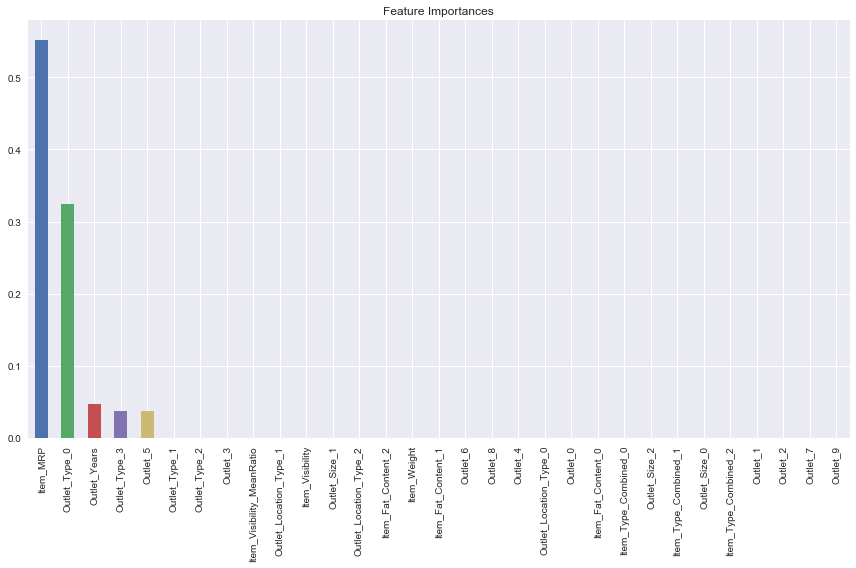

In [38]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg, train, test, predictors, target, IDcol, 'random_forest_model_1')
coef = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('random_forest_1_coefficients')

- You might feel this is a very small improvement but as our model gets better, achieving even minute improvements becomes exponentially difficult. Lets try another random forest with max_depth of 6 and 400 trees. Increasing the number of trees makes the model robust but is computationally expensive.


Model Report
RMSE : 1068
CV Score : Mean - 1083 | Std - 43.65 | Min - 1019 | Max - 1161
Saving model random_forest_model_2
Saving submission random_forest_model_2
Saving figure random_forest_2_coefficients


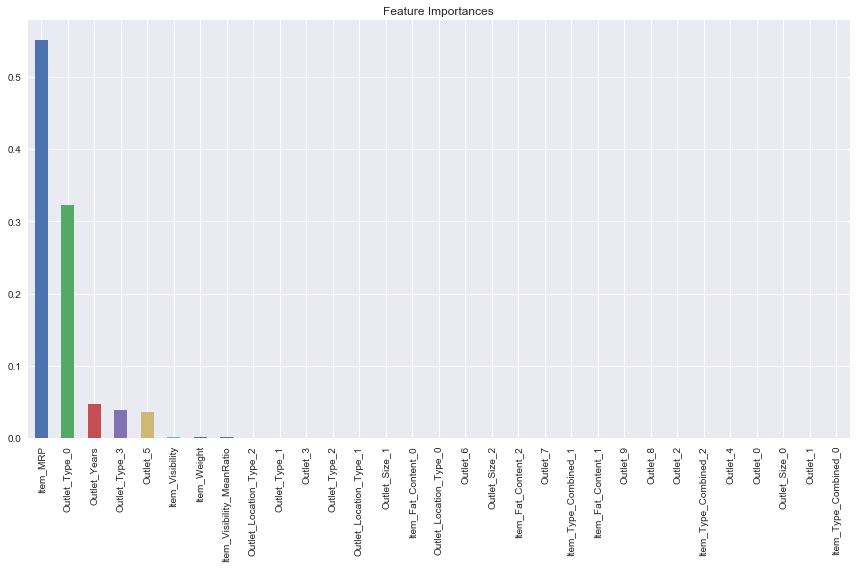

In [39]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg, train, test, predictors, target, IDcol, 'random_forest_model_2')
coef = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('random_forest_2_coefficients')

- Again this is an incremental change but will help you get a jump of 5-10 ranks on leaderboard. We try to tune the parameters further to get higher accuracy as well as experiment with GBM and XGBoost and ensembles. 

# Model Fine-Tuning
In order to fine tune our models, we need to test out different hyperparameters using both Grid Search and Randomized Search. We'll create a function that allows us to execute different combinations easily.

## Function to Perform Grid Search Cross-Validation

In [56]:
from sklearn.model_selection import GridSearchCV

def model_tune_gridsearch(model_name, alg, hyperparams, cv, dtrain, dtest, predictors, target, IDcol, verbose):
    
    #Perform GridCV:
    grid = GridSearchCV(estimator=alg, cv=cv, param_grid=hyperparams, 
                        scoring='neg_mean_squared_error', return_train_score=True, verbose=verbose, n_jobs=4)
    grid.fit(dtrain[predictors], dtrain[target])
    
    #Print model report:
    print ("\nModel Report - ", model_name)
    print('-'*len("Model Report - " + model_name))
    print("Best RMSE Score: {}".format(np.sqrt(abs(grid.best_score_))))
    print("Best Parameters: {}\n".format(grid.best_params_))
    
    #Predict on testing data:
    dtest[target] = grid.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    save_model(submission, model_name)
    save_submission(submission, model_name)
    
    return grid

## Function to Perform Random Search Cross-Validation

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

def model_tune_randomsearch(model_name, alg, hyperparams, cv, n_iter, n_jobs, dtrain, dtest, predictors, target, IDcol, verbose):
    
    #Perform RandomSearchCV:
    rnd_search = RandomizedSearchCV(estimator=alg, cv=cv, param_distributions=hyperparams, 
                              scoring='neg_mean_squared_error', n_jobs=n_jobs, 
                                    n_iter=n_iter, verbose=verbose, random_state=42)
    rnd_search.fit(dtrain[predictors], dtrain[target])
    
    #Print model report:
    print ("\nModel Report - ", model_name)
    print('-'*len("Model Report - " + model_name))
    print("Best RMSE Score: {}".format(np.sqrt(abs(rnd_search.best_score_))))
    print("Best Parameters: {}\n".format(rnd_search.best_params_))
    
    #Predict on testing data:
    dtest[target] = rnd_search.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    save_model(submission, model_name)
    save_submission(submission, model_name)
    
    return rnd_search

## Random Forest Grid Search CV

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.1s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=3 ..................................
[CV] ................... max_features=2, n_estimators=3, total=   0.0s
[CV] max_features=2, n_estimators=10 .................................
[CV] .

[CV] ................... max_features=6, n_estimators=3, total=   0.0s
[CV] max_features=6, n_estimators=3 ..................................
[CV] ................... max_features=6, n_estimators=3, total=   0.0s
[CV] max_features=6, n_estimators=3 ..................................
[CV] ................... max_features=6, n_estimators=3, total=   0.0s
[CV] max_features=6, n_estimators=3 ..................................
[CV] ................... max_features=6, n_estimators=3, total=   0.0s
[CV] max_features=6, n_estimators=3 ..................................
[CV] ................... max_features=6, n_estimators=3, total=   0.0s
[CV] max_features=6, n_estimators=3 ..................................
[CV] ................... max_features=6, n_estimators=3, total=   0.1s
[CV] max_features=6, n_estimators=3 ..................................
[CV] ................... max_features=6, n_estimators=3, total=   0.0s
[CV] max_features=6, n_estimators=10 .................................
[CV] .

[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.1s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.1s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.1s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.1s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.1s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.0s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .. bootstrap=False, max_features=2, n_estimators=3, total=   0.1s
[CV] bootstrap=False, max_features=2, n_estimators=3 .................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   39.9s finished



Model Report -  random_forest_gridcv_1
-------------------------------------
Best RMSE Score: 1138.570241646363
Best Parameters: {'max_features': 6, 'n_estimators': 30}

Saving model random_forest_gridcv_1
Saving submission random_forest_gridcv_1
Saving figure random_forest_1_coefficients


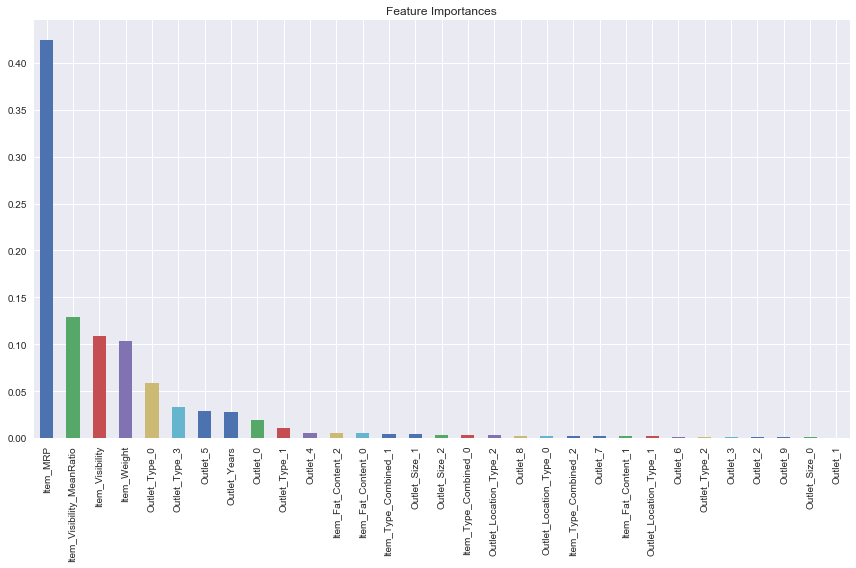

In [54]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
hyperparameters = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

alg = RandomForestRegressor(random_state=42)
grid = model_tune_gridsearch("random_forest_gridcv_1", alg, hyperparameters, 10, 
                             train, test, predictors, target, IDcol, 2)
coef = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('random_forest_1_coefficients')

In [57]:
predictors = ["Item_MRP", "Item_Visibility_MeanRatio", "Item_Visibility", "Item_Weight", "Outlet_Type_0", "Outlet_Type_3"]
hyperparameters = [
    {'n_estimators': [4500], 'max_features': [6]},
  ]

alg = RandomForestRegressor(random_state=42)
grid = model_tune_gridsearch("random_forest_gridcv_2", alg, hyperparameters, 10, 
                             train, test, predictors, target, IDcol, 2)
coef = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('random_forest_gridcv_2_coefficients')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_features=6, n_estimators=4500 ...............................
[CV] max_features=6, n_estimators=4500 ...............................
[CV] max_features=6, n_estimators=4500 ...............................
[CV] max_features=6, n_estimators=4500 ...............................


KeyboardInterrupt: 

## Random Forest Random Search CV

In [ ]:
from scipy.stats import randint

predictors = ["Item_MRP", "Item_Visibility_MeanRatio", "Item_Visibility", "Item_Weight", "Outlet_Type_0", "Outlet_Type_3"]
hyperparameters = {
    'n_estimators': randint(low=5000, high=7000),
    'max_features': randint(low=1, high=6),
}

alg = RandomForestRegressor(random_state=42)
rnd_search = model_tune_randomsearch("random_forest_randomcv_1", alg, hyperparameters, 5, 10, 4, 
                               train, test, predictors, target, IDcol, 2)
coef = pd.Series(rnd_searcho.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances', figsize=(12, 8))

save_fig('random_forest_randomcv_1_coefficients')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_features=4, n_estimators=5860 ...............................
[CV] max_features=4, n_estimators=5860 ...............................
[CV] max_features=4, n_estimators=5860 ...............................
[CV] max_features=4, n_estimators=5860 ...............................
